### link_to_view_the_model_performance: https://www.linkedin.com/posts/hui-liu-3b705a245_maskdetection-computervision-deeplearning-activity-7026626192317288448-JvRi?utm_source=share&utm_medium=member_desktop

### imports 

In [127]:
import numpy as np
import pandas as pd
import os
import shutil
import xml
import random
#from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense
from keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKeras
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight 


### create dictionaries 

In [656]:
root_dir = os.getcwd()+'/root'
annot_dir = os.path.join(root_dir, 'annotations')
img_dir = os.path.join(root_dir, 'images')
cropped_img_dir = os.path.join(root_dir, 'cropped_images')

In [586]:
with_mask_dir = os.path.join(root_dir, 'with_mask')
without_mask_dir = os.path.join(root_dir, 'without_mask')

In [587]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [657]:
create_dir(with_mask_dir)
create_dir(without_mask_dir)
create_dir(cropped_img_dir)

In [589]:
base_dir = os.path.join('base')
train_dir = os.path.join(base_dir, 'train')
train_with_mask_dir = os.path.join(train_dir, 'with_mask')
train_without_mask_dir = os.path.join(train_dir, 'without_mask')

validation_dir = os.path.join(base_dir, 'validation')
validation_with_mask_dir = os.path.join(validation_dir, 'with_mask')
validation_without_mask_dir = os.path.join(validation_dir, 'without_mask')

test_dir = os.path.join(base_dir, 'test')
test_with_mask_dir = os.path.join(test_dir, 'with_mask')
test_without_mask_dir = os.path.join(test_dir, 'without_mask')

In [590]:
create_dir(base_dir)

create_dir(train_dir)
create_dir(train_with_mask_dir)
create_dir(train_without_mask_dir)
create_dir(validation_dir)
create_dir(validation_with_mask_dir)
create_dir(validation_without_mask_dir)
create_dir(test_dir)
create_dir(test_with_mask_dir)
create_dir(test_without_mask_dir)

### before preprocessing the images, check what information we have for each image

In [142]:
# first of all, we need to label the images (with_mask, or without_mask)

In [648]:
tree = ET.parse(os.path.join(annot_dir,os.listdir(annot_dir)[0]))
root = tree.getroot()
for i in tree.iter():
    print(i) # annotation file includes the following information

<Element 'annotation' at 0x16b822700>
<Element 'folder' at 0x16b8227a0>
<Element 'filename' at 0x16b8222f0>
<Element 'size' at 0x16b822390>
<Element 'width' at 0x16b8223e0>
<Element 'height' at 0x16b822430>
<Element 'depth' at 0x16b822520>
<Element 'segmented' at 0x16b8227f0>
<Element 'object' at 0x16b8215d0>
<Element 'name' at 0x16b8222a0>
<Element 'pose' at 0x16b822480>
<Element 'truncated' at 0x16b821d50>
<Element 'occluded' at 0x16b821f30>
<Element 'difficult' at 0x16b821df0>
<Element 'bndbox' at 0x16b8218f0>
<Element 'xmin' at 0x16b8214e0>
<Element 'ymin' at 0x16b8212b0>
<Element 'xmax' at 0x16b821300>
<Element 'ymax' at 0x16b821580>


### create the dataframe with label information for every face

In [653]:
def parse_annotation(path):
    tree = ET.parse(path)
    root = tree.getroot()
    constants = {}
    objects = [child for child in root if child.tag == 'object']
    for element in tree.iter():
        if element.tag == 'filename':
            constants['filename'] = element.text
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    object_params = [parse_annotation_object(obj) for obj in objects]
    #print(constants)
    full_result = [merge(constants,ob) for ob in object_params]
    return full_result   


def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['mask_or_not'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)              
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)
            
    return params       
 
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [654]:
dataset = [parse_annotation(anno) for anno in glob.glob(annot_dir+"/*.xml") ]

full_dataset = sum(dataset, []) 

df = pd.DataFrame(full_dataset)
df.head()

,filename,width,height,depth,mask_or_not,xmin,ymin,xmax,ymax
0,maksssksksss299.png,301,400,3,without_mask,62,194,160,320
1,maksssksksss528.png,301,400,3,without_mask,43,169,149,308
2,maksssksksss272.png,275,400,3,mask_weared_incorrect,48,107,218,304
3,maksssksksss514.png,400,267,3,with_mask,28,78,43,99
4,maksssksksss514.png,400,267,3,with_mask,160,66,176,83


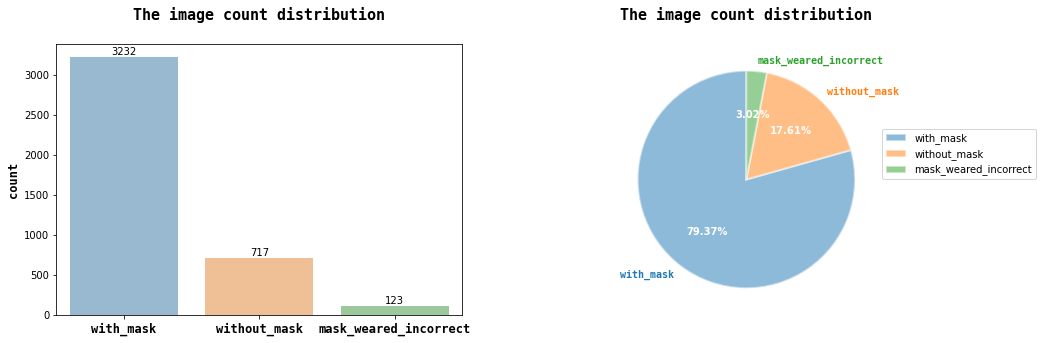

In [655]:
fig,axes = plt.subplots(1,2,figsize=(16,5))
sns.barplot(data=df['mask_or_not'].value_counts().reset_index(), x='index', y='mask_or_not',ax=axes[0], alpha=0.5)
for i in axes[0].get_xticklabels():
    i.set_font('monospace')
    i.set_weight('semibold')
    i.set_size(12)
for j in axes[0].containers:
    axes[0].bar_label(j)
    
axes[0].set_xlabel('')
axes[0].set_ylabel('count', font='monospace', weight='semibold', size=12)
axes[0].set_title('The image count distribution\n', font='monospace', weight='semibold', size=15)

patches, texts, pcts = axes[1].pie(df['mask_or_not'].value_counts().reset_index()['mask_or_not'], labels=df['mask_or_not'].value_counts().reset_index()['index'], wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
            textprops={'size': 'x-large'}, startangle=90, autopct='%1.2f%%');
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
    patch.set_alpha(0.5)
for j in pcts:
    j.set_size(10)
    j.set_color('white')
    j.set_weight('semibold')
plt.setp(texts, fontweight='semibold', font='monospace')
axes[1].legend(loc=[1,0.5])
axes[1].set_title('The image count distribution\n', font='monospace', weight='semibold', size=15);

### see some faces from a sample image

In [635]:
df['filename'].value_counts().head(10) # the last image has 26 faces in it, let's see how they look

maksssksksss603.png    115
maksssksksss518.png     83
maksssksksss240.png     61
maksssksksss260.png     53
maksssksksss52.png      51
maksssksksss539.png     41
maksssksksss296.png     35
maksssksksss89.png      29
maksssksksss695.png     28
maksssksksss110.png     26
Name: filename, dtype: int64

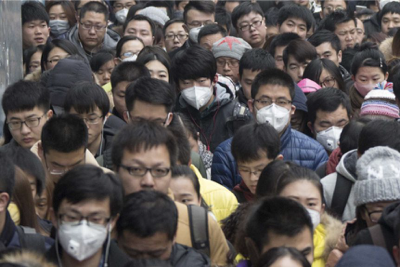

In [637]:
Image.open(os.path.join(img_dir, 'maksssksksss110.png'))

In [526]:
# let's see some faces from this image

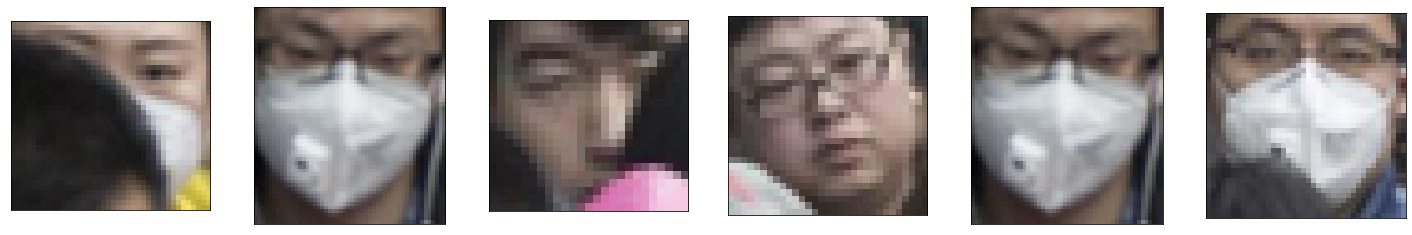

In [644]:
faces=[]
for i, j in df[df['filename']=='maksssksksss110.png'].iterrows():
    xmin = j['xmin']
    xmax = j['xmax']
    ymin = j['ymin']
    ymax = j['ymax']
    img = Image.open(os.path.join(img_dir,'maksssksksss110.png'))
    faces.append(np.array(img)[ymin:ymax, xmin:xmax:, :])
    
fig, axes = plt.subplots(1,6, figsize=(25,4),subplot_kw=dict(xticks=[], yticks=[]))
for i, ax in enumerate(axes.flat):
    ax.imshow(random.sample(faces,6)[i])

### crop all the images and move the cropped images to cropped_img_dir

In [658]:
for file in df['filename'].unique():
    for index, row in df[df['filename']==file].iterrows():
        xmin = row['xmin']
        xmax = row['xmax']
        ymin = row['ymin']
        ymax = row['ymax']
        img = Image.open(os.path.join(img_dir,file))
        cropped_array = np.array(img)[ymin:ymax, xmin:xmax:, :]
        cropped_img = Image.fromarray(cropped_array)
        cropped_img.save(os.getcwd()+'/root/cropped_images/'+ str(index)+'.png')

### distribute the images to trian, validation, and test files

In [163]:
# copy images files to with_mask_dir, and without_mask_dir 

In [673]:
def copy_images(source_path, destination_path, copied_images):
    for i in copied_images:
        shutil.copy(os.path.join(source_path, str(i)+'.png'), os.path.join(destination_path, str(i)+'.png'))

In [674]:
copy_images(cropped_img_dir, with_mask_dir, df[(df['mask_or_not']=='with_mask')|(df['mask_or_not']=='mask_weared_incorrect')].index)

In [675]:
copy_images(cropped_img_dir, without_mask_dir,df[df['mask_or_not']=='without_mask'].index)

In [167]:
# split the data into train and validation sets

In [678]:
def split_data(source_path, train_set, validation_set, test_set, split_ratio):
    train_size = int(len(os.listdir(source_path))*split_ratio)
    train_selected = random.sample(os.listdir(source_path), train_size)
    for T in train_selected:
        shutil.copy(os.path.join(source_path, T), os.path.join(train_set, T))
    
    not_train = [img for img in os.listdir(source_path) if img not in train_selected]
    
    validation_selected = random.sample(not_train, int(0.5*len(not_train)))
    for V in validation_selected:
        shutil.copy(os.path.join(source_path, V), os.path.join(validation_set, V))
    
    test_selected = [img for img in not_train if img not in validation_selected]
    for R in test_selected:
        shutil.copy(os.path.join(source_path, R), os.path.join(test_set, R))

In [679]:
split_data(with_mask_dir, train_with_mask_dir, validation_with_mask_dir, test_with_mask_dir, 0.8)
split_data(without_mask_dir, train_without_mask_dir, validation_without_mask_dir, test_without_mask_dir,0.8)

In [691]:
print(f'There are {len(os.listdir(train_with_mask_dir))} in train_with_mask dir')
print(f'There are {len(os.listdir(train_without_mask_dir))} in train_without_mask dir\n')
print(f'There are {len(os.listdir(validation_with_mask_dir))} in validation_with_mask dir')
print(f'There are {len(os.listdir(validation_without_mask_dir))} in validation_without_mask dir\n')
print(f'There are {len(os.listdir(test_with_mask_dir))} in test_with_mask dir')
print(f'There are {len(os.listdir(test_without_mask_dir))} in test_without_mask dir')

There are 2684 in train_with_mask dir
There are 573 in train_without_mask dir

There are 335 in validation_with_mask dir
There are 72 in validation_without_mask dir

There are 336 in test_with_mask dir
There are 72 in test_without_mask dir


### visualize the images

In [705]:
imgs_path = []
for i in os.listdir(train_dir)[1:]:
    imgs = os.listdir(os.path.join(train_dir, i))
    chosen_imgs = random.sample(imgs, 8)
    for j in chosen_imgs:
        imgs_path.append(os.path.join(train_dir, i, j))

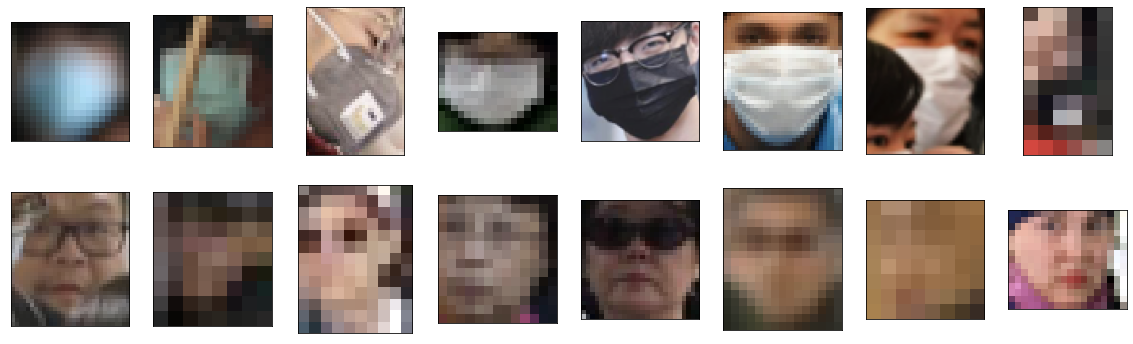

In [706]:
fig, axes = plt.subplots(len(os.listdir(train_dir))-1, 8, figsize=(20,6), subplot_kw = dict(xticks=[], yticks=[]))
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(imgs_path[i]))

### data generator

In [790]:
train_generator = ImageDataGenerator(rescale=1.0 / 255, 
                                     horizontal_flip=True, 
                                     zoom_range=0.1, 
                                     shear_range=0.2, 
                                     width_shift_range=0.1,
                                     height_shift_range=0.1, 
                                     rotation_range=4, 
                                     vertical_flip=False)

validation_generator = ImageDataGenerator(rescale=1./255)

test_generator = ImageDataGenerator(rescale=1./255)

In [791]:
train_data_gen = train_generator.flow_from_directory(train_dir, 
                                                     class_mode='categorical', 
                                                     target_size=(48,48),
                                                     batch_size=32,shuffle=True)

validation_data_gen = validation_generator.flow_from_directory(validation_dir, 
                                                     class_mode='categorical', 
                                                     target_size=(48,48),
                                                     batch_size=32,shuffle=False)

test_data_gen = test_generator.flow_from_directory(test_dir, 
                                                     class_mode='categorical', 
                                                     target_size=(48,48),
                                                     batch_size=32,shuffle=False)

Found 3257 images belonging to 2 classes.
Found 407 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


In [792]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', 
                                                  classes = np.unique(train_data_gen.classes), 
                                                  y = train_data_gen.classes)

train_class_weights = dict(enumerate(class_weights))

### train the model

In [793]:
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (48,48,3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 256, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Flatten())
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dense(2,activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_112 (Conv2D)         (None, 48, 48, 64)        1792      
                                                                 
 max_pooling2d_112 (MaxPooli  (None, 24, 24, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_113 (Conv2D)         (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_113 (MaxPooli  (None, 12, 12, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_114 (Conv2D)         (None, 12, 12, 256)       147712    
                                                                 
 max_pooling2d_114 (MaxPooli  (None, 6, 6, 256)      

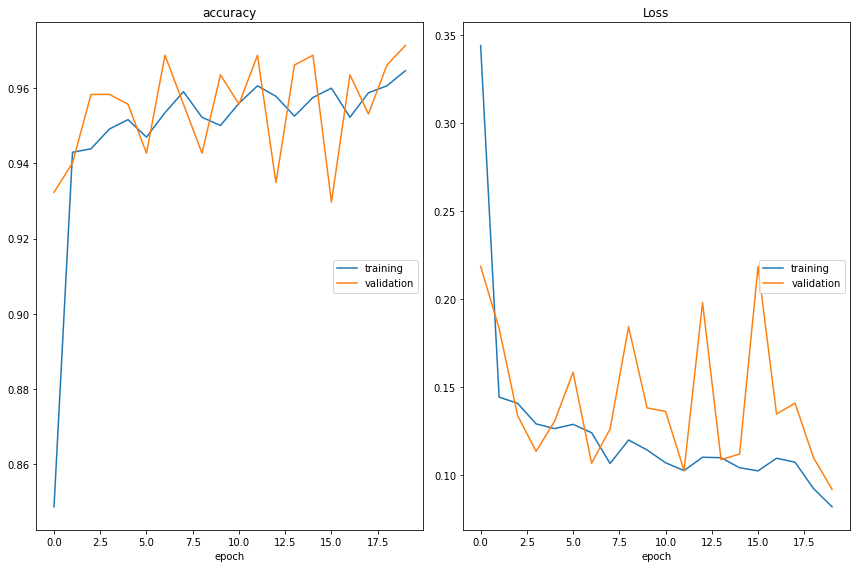

accuracy
	training         	 (min:    0.849, max:    0.965, cur:    0.965)
	validation       	 (min:    0.930, max:    0.971, cur:    0.971)
Loss
	training         	 (min:    0.082, max:    0.344, cur:    0.082)
	validation       	 (min:    0.092, max:    0.219, cur:    0.092)

Epoch 20: saving model to model_weights.h5
101/101 [==============================] - 12s 123ms/step - loss: 0.0819 - accuracy: 0.9647 - val_loss: 0.0919 - val_accuracy: 0.9714


In [794]:
epochs = 20
steps_per_epoch = train_data_gen.n//32
validation_steps = validation_data_gen.n//32

checkpoint = ModelCheckpoint('model_weights.h5', monitor='val_accuracy',save_weight_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001, mode='auto')
callbacks=[PlotLossesKeras(), checkpoint, reduce_lr]

history = model.fit(x=train_data_gen, 
                    steps_per_epoch = steps_per_epoch,
                    epochs=epochs,
                    validation_data=validation_data_gen, 
                    validation_steps=validation_steps,
                    callbacks=callbacks,
                    class_weight=train_class_weights)

### evaluate the model

In [805]:
model.evaluate(test_data_gen)

13/13 [==============================] - 0s 25ms/step - loss: 0.1067 - accuracy: 0.9632


[0.10674221068620682, 0.9632353186607361]

In [812]:
pred = model.predict(test_data_gen, test_data_gen.n//test_data_gen.batch_size)

13/13 [==============================] - 0s 27ms/step


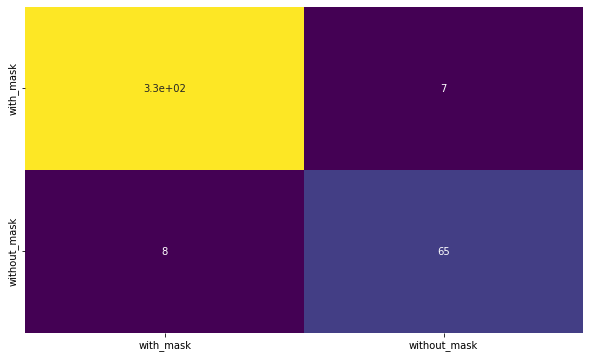

In [813]:
sns.heatmap(confusion_matrix(np.argmax(pred,axis=1), test_data_gen.classes), annot=True, 
            xticklabels=test_data_gen.class_indices.keys(),
           yticklabels=test_data_gen.class_indices.keys(), cbar=False, cmap='viridis')
fig=plt.gcf()
fig.set_size_inches(10,6);

In [808]:
print(classification_report(np.argmax(pred,axis=1),test_data_gen.classes))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       335
           1       0.90      0.89      0.90        73

    accuracy                           0.96       408
   macro avg       0.94      0.93      0.94       408
weighted avg       0.96      0.96      0.96       408



### save the model

In [809]:
model_json = model.to_json()
with open('model_json', 'w') as json_file:
    json_file.write(model_json)